In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch #for using tensors
import torch.nn as nn # creating neural network
import torch.nn.functional as F # recallable functions like relu,sigmoid and etc.
import torchvision # subpackage for vision models
import torchvision.transforms as transforms # image augmentation
import torch.optim as optim # optimisation functions like sgd, adam
from torch.utils.data import DataLoader # creating a data loader
from torchvision.transforms import ToTensor # converting image to tensor
import matplotlib.pyplot as plt 
from torch.utils.data.sampler import SubsetRandomSampler

# Defining data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Downloading and loading the CIFAR-10 training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Downloading and loading the CIFAR-10 test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Creating data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


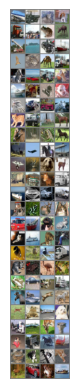

In [2]:
#Showing random batches of images
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images, nrow=4)
grid = grid.permute(1, 2, 0).numpy()
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
grid = std * grid + mean
plt.imshow(grid)
plt.axis('off')
plt.show()

In [3]:
#Getting info about the train set
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [4]:
#Getting info about the test set
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [5]:
#Checking the size of the first image in the train set
trainset[0][0].size()

torch.Size([3, 32, 32])

In [6]:
#Visualizing a batch of data
for x,y in trainloader:
    print(x.shape)
    print(y)
    break

torch.Size([100, 3, 32, 32])
tensor([6, 9, 5, 4, 6, 8, 9, 4, 0, 2, 2, 2, 4, 8, 6, 4, 7, 8, 2, 5, 4, 0, 6, 9,
        2, 0, 4, 2, 9, 8, 1, 9, 9, 0, 5, 3, 0, 4, 1, 7, 1, 4, 9, 2, 8, 5, 2, 4,
        8, 0, 4, 6, 2, 6, 5, 1, 8, 4, 5, 6, 2, 7, 9, 9, 1, 6, 0, 2, 3, 6, 5, 3,
        5, 7, 5, 1, 8, 9, 7, 0, 7, 8, 0, 4, 7, 5, 8, 2, 6, 7, 8, 3, 7, 4, 7, 3,
        7, 9, 3, 6])


In [7]:
#Creating the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Choosing 3 input channels because we have colored images as input
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=8,padding=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=7,stride=2,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*7*7,256)
        self.fc2 = nn.Linear(256,256)
        #Choosing 10 for the output layer because we have 10 unique labels
        self.out = nn.Linear(256,10)
        self.drop_out = nn.Dropout()
    def forward(self,X):
        # input image size is [3,32,32]
        X = self.conv1(X)
        # (32-8+2*2)/1+1 -> 29
        # our result will be [64,29,29]
        X = self.conv2(X)
        # (29-7+2*2)/2 + 1 -> 14
        # [128,14,14]
        X = self.pool(X)
        # 14/2 -> 7
        # [128,7,7]
        X = X.reshape(X.size(0), -1)
        # [ 128*7*7] -> one dimension
        X = self.drop_out(X)
        # Regularization and preventing the co-adaptation of neurons
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        out = self.out(X)
        return X

In [8]:
#Defining the model
model = NeuralNetwork()
model = model.to("cuda")

In [9]:
num_epochs = 7
learning_rate = 0.001 

In [10]:
#Specifying the loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [11]:
#Training the model and visualizing the losses and accuracy
total_step = len(trainloader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Run the forward pass
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/7], Step [100/500], Loss: 1.6878, Accuracy: 43.00%
Epoch [1/7], Step [200/500], Loss: 1.5958, Accuracy: 48.00%
Epoch [1/7], Step [300/500], Loss: 1.2903, Accuracy: 54.00%
Epoch [1/7], Step [400/500], Loss: 1.5016, Accuracy: 46.00%
Epoch [1/7], Step [500/500], Loss: 1.0122, Accuracy: 61.00%
Epoch [2/7], Step [100/500], Loss: 1.0909, Accuracy: 59.00%
Epoch [2/7], Step [200/500], Loss: 1.0936, Accuracy: 58.00%
Epoch [2/7], Step [300/500], Loss: 1.1611, Accuracy: 59.00%
Epoch [2/7], Step [400/500], Loss: 1.2151, Accuracy: 60.00%
Epoch [2/7], Step [500/500], Loss: 1.0890, Accuracy: 61.00%
Epoch [3/7], Step [100/500], Loss: 0.9394, Accuracy: 60.00%
Epoch [3/7], Step [200/500], Loss: 0.8600, Accuracy: 74.00%
Epoch [3/7], Step [300/500], Loss: 0.9447, Accuracy: 65.00%
Epoch [3/7], Step [400/500], Loss: 0.9259, Accuracy: 68.00%
Epoch [3/7], Step [500/500], Loss: 0.9763, Accuracy: 64.00%
Epoch [4/7], Step [100/500], Loss: 0.8324, Accuracy: 73.00%
Epoch [4/7], Step [200/500], Loss: 0.895

In [12]:
#Testing the model. The accuracy for test data is very similar to that of train data so we don't have overfitting.
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 69.41000000000001 %


In [13]:
#Saving the model
torch.save(model.state_dict(), 'drive/MyDrive/model_cifar.pth')

In [14]:
#loading the model
model = NeuralNetwork()
model = model.to("cuda")
model.load_state_dict(torch.load('drive/MyDrive/model_cifar.pth'))

<All keys matched successfully>